# BAP1 cis comparison


BAP1 is known as a tumor suppressor and a deubiquitinase. "The presence of ubiquitin molecules on a protein can affect the activity of the protein and its interactions with other proteins. The ubiquitin "tag" also promotes breakdown (degradation) of a protein. By removing ubiquitin, BAP1 helps regulate the function of many proteins involved in diverse cellular processes. The BAP1 protein is thought to help control cell growth and division (proliferation) and cell death" (https://ghr.nlm.nih.gov/gene/BAP1).

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

In [2]:
def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        #sites = len(comparison_columns.columns)
        number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        all_comparisons_sig_col = f.add_significance_col(all_comparisons_df, number_of_comparisons)
        return all_comparisons_sig_col
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None


## Step 2: Find the mutation frequency of BAP1 for Kidney Cancer

In [3]:
rc = cptac.RenalCcrcc()
desired_cutoff = 0.1
gene = 'BAP1'

freq_mut = al.get_frequently_mutated(rc, cutoff = desired_cutoff)
freq_mut.loc[freq_mut['Gene'] == gene]

,Gene,Unique_Samples_Mut,Missense_Mut,Truncation_Mut
0,BAP1,0.154545,0.063636,0.090909


## Step 3: cis comparisons for omics 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

# Proteomics cis comparison

Proteomics: Mutated and Wildtype

In [5]:
prot_mut_status = f.format_cis_comparison_data(rc, 'proteomics', gene)

cis_tests = len(freq_mut) 
prot_col_list = [gene+'_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(prot_mut_status, 'binary_mutations', prot_col_list, cis_tests)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

Doing t-test comparison for mutated and wildtype


,Comparison,P_Value,Significant
Mutated/Wildtype,BAP1_proteomics,0.010487,False


This p-value is not significant because of multiple hypothesis testing. Other notebooks test the rest of the frequently mutated genes. 

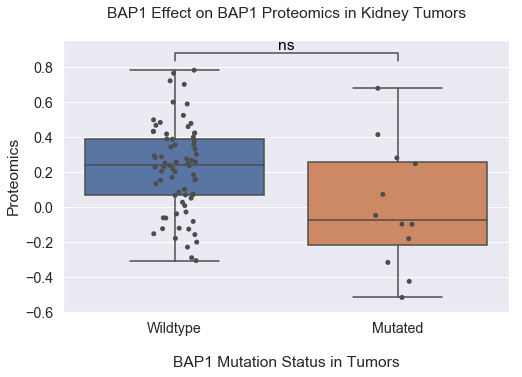

In [6]:
f.cis_plot(prot_mut_status, gene, "proteomics", prot_results)

Proteomics: Missense and Truncation compared to wildtype

In [10]:
# Create data frame with mutation types and wildtype binary column
prot_mut_type = f.get_missense_truncation_comparison(rc, 'proteomics', gene)
prot_wildtype = prot_mut_status.loc[prot_mut_status['binary_mutations'] == 'Wildtype'] # select all wildtype 
prot_mut_and_wildtype = prot_mut_type.append(prot_wildtype, sort=False) # use for graph

# compare missense and wildtype
prot_miss_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype")
prot_results_miss = wrap_ttest_return_all(prot_miss_wt, 'binary_mutations', prot_col_list, cis_tests)
prot_results_miss = prot_results_miss.rename(index = {0: "Missense/Wildtype"})

# compare truncation and wildtype
prot_trunc_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
prot_results_trunc = wrap_ttest_return_all(prot_trunc_wt, 'binary_mutations', prot_col_list, cis_tests)
prot_results_trunc = prot_results_trunc.rename(index = {0: "Truncation/Wildtype"})

prot_results_miss_trunc = prot_results_miss.append(prot_results_trunc)
prot_results_miss_trunc

Doing t-test comparison for missense and wildtype
Doing t-test comparison for truncation and wildtype


,Comparison,P_Value,Significant
Missense/Wildtype,BAP1_proteomics,0.293014,False
Truncation/Wildtype,BAP1_proteomics,0.004736,True


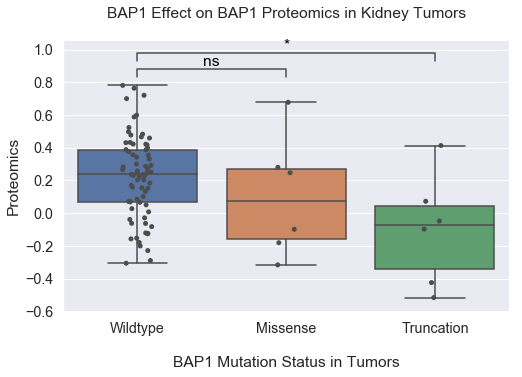

In [12]:
f.cis_plot(prot_mut_and_wildtype, gene, "proteomics", prot_results_miss_trunc)

# Transcriptomics cis comparison

Transcriptomics: Mutated and Wildtype

In [18]:
trans_col_list = [gene+'_transcriptomics']
trans_col = gene+'_transcriptomics'
trans_mut_status = f.format_cis_comparison_data(rc, 'transcriptomics', gene)

print("Doing t-test comparison for mutation status")
transcrpt_results = wrap_ttest_return_all(trans_mut_status, 'binary_mutations', trans_col_list, cis_tests)
transcrpt_results = transcrpt_results.rename(index = {0: "Mutated/Wildtype"})
transcrpt_results

Doing t-test comparison for mutation status


,Comparison,P_Value,Significant
Mutated/Wildtype,BAP1_transcriptomics,0.010493,False


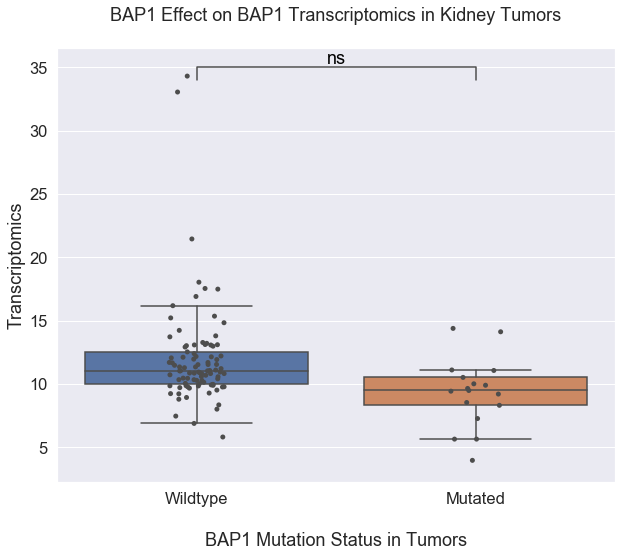

In [32]:
#f.cis_plot(trans_mut_status, gene, 'transcriptomics', transcrpt_results)
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.5)
cis_boxplot = sns.boxplot(data = trans_mut_status, x = 'binary_mutations',
                          y = trans_col, order = ['Wildtype', 'Mutated'], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene +" Transcriptomics in Kidney Tumors\n")
cis_boxplot = sns.stripplot(data= trans_mut_status, x = 'binary_mutations',
                            y = trans_col,jitter = True, color = ".3", order = ['Wildtype', 'Mutated'])
cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = 'Transcriptomics')
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())

mut_pval_symbol = f.get_pval_symbol(transcrpt_results)
f.format_pval_annotation(mut_pval_symbol, x1 = 0, x2 = 1, line_start = 34, line_height = 1)

plt.show()
plt.clf()
plt.close()

Transcriptomics: Missense and Truncation

In [25]:
# select all wildtype from earlier -add to mut_type binary column
trans_wildtype = trans_mut_status.loc[trans_mut_status['binary_mutations'] == 'Wildtype'] 
trans_mut_type = f.get_missense_truncation_comparison(rc, 'transcriptomics', gene)
trans_mut_and_wildtype = trans_mut_type.append(trans_wildtype, sort=False) # use for graph

# compare missense and wildtype
miss_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype")
trans_results_miss = wrap_ttest_return_all(miss_wt, 'binary_mutations', trans_col_list, cis_tests)
trans_results_miss = trans_results_miss.rename(index = {0: "Missense/Wildtype"})

# compare truncation and wildtype
trunc_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
trans_results_trunc = wrap_ttest_return_all(trunc_wt, 'binary_mutations', trans_col_list, cis_tests)
trans_results_trunc = trans_results_trunc.rename(index = {0: "Truncation/Wildtype"})

trans_results_miss_trunc = trans_results_miss.append(trans_results_trunc)
trans_results_miss_trunc

Doing t-test comparison for missense and wildtype
Doing t-test comparison for truncation and wildtype


,Comparison,P_Value,Significant
Missense/Wildtype,BAP1_transcriptomics,0.147160,False
Truncation/Wildtype,BAP1_transcriptomics,0.028673,False


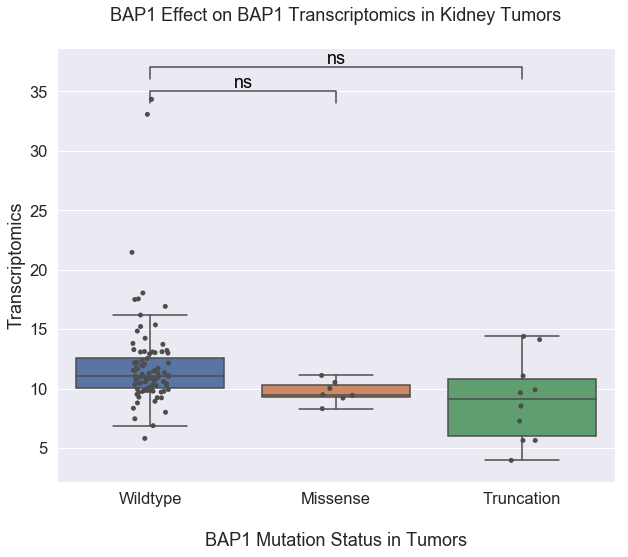

In [33]:
#f.cis_plot(trans_mut_and_wildtype, gene, 'transcriptomics', trans_results_miss_trunc)
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.5)
cis_boxplot = sns.boxplot(data = trans_mut_and_wildtype, x = 'binary_mutations',
                          y = trans_col, order = ['Wildtype', 'Missense', 'Truncation'], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene +" Transcriptomics in Kidney Tumors\n")
cis_boxplot = sns.stripplot(data= trans_mut_and_wildtype, x = 'binary_mutations',
                            y = trans_col,jitter = True, color = ".3", order = ['Wildtype', 'Missense', 'Truncation'])
cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = 'Transcriptomics')
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())

# Missense
miss_pval = trans_results_miss_trunc.loc[trans_results_miss_trunc.index == "Missense/Wildtype"]
miss_pval_symbol = f.get_pval_symbol(miss_pval)
f.format_pval_annotation(miss_pval_symbol, x1 = 0, x2 = 1, line_start = 34, line_height = 1)

# Truncation 
trunc_pval = trans_results_miss_trunc.loc[trans_results_miss_trunc.index == "Truncation/Wildtype"]
trunc_pval_symbol = f.get_pval_symbol(trunc_pval)
f.format_pval_annotation(miss_pval_symbol, x1 = 0, x2 = 2, line_start = 36, line_height = 1)

plt.show()
plt.clf()
plt.close()

# Phosphoproteomics cis comparison

Phosphoproteomics: Mutated and Wildtype

In [6]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
omics_and_mut = rc.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

# Step 2 - Create the binary column needed to do the comparison
omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
omics_and_mut = omics_and_mut.query('Sample_Status != "Normal"') # changed because warning with slice
#tumors = omics_and_mut.loc[omics_and_mut['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = omics_and_mut.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)

In [7]:
def rename_columns(df):
    cols = []
    one_before = ''
    two_before = ''
    for column in df.columns:

        if column == one_before: 
            column = column+"_"+str(2)
            cols.append(column)
            two_before = one_before
            one_before = column
            continue

        elif column == two_before:
            column = column+"_"+str(3)
            cols.append(column)
            two_before = one_before
            one_before = column
            continue
        else:
            cols.append(column)
            two_before = one_before
            one_before = column
            continue
            
    df.columns = cols
    return df

In [8]:
binary_phospho_renamed = rename_columns(binary_phospho)

In [9]:
# Use al.wrap_ttest for many columns of phospho data
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results = al.wrap_ttest(binary_phospho_renamed, 'binary_mutations', phos_col_list)
phos_pval_results['Significant'] = 'True'
phos_pval_results = phos_pval_results.rename(index = {0: "Mutated/Wildtype"})
phos_pval_results

Doing t-test comparison for mutation status


C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,Comparison,P_Value,Significant
Mutated/Wildtype,BAP1-S597_phosphoproteomics,8.741863e-11,True
1,BAP1-S525_phosphoproteomics,1.538202e-06,True
2,BAP1-S521_phosphoproteomics,1.484106e-04,True


Graph

In [10]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(phos_pval_results['Comparison'])
phospho_df = pd.melt(binary_phospho_renamed, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names

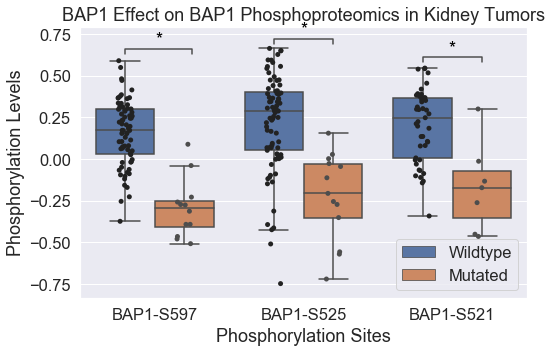

In [11]:
plt.rcParams['figure.figsize']=(8,5) #size of plot
sns.set(font_scale = 1.5)

cis_boxplot = sns.boxplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False) 
cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Kidney Tumors")
cis_boxplot = sns.stripplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())

# format legend
handles, labels = cis_boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

# pval annotations for 
f.format_pval_annotation('*', x1 = -.2, x2 = .25, line_start = .63, line_height = .03)
# pval annotations for 
f.format_pval_annotation('*', x1 = .8, x2 = 1.2, line_start = .69, line_height = .03)

f.format_pval_annotation('*', x1 = 1.8, x2 = 2.2, line_start = .58, line_height = .03)

plt.show()
plt.clf()
plt.close()


Phosphoproteomics: Missense and Truncation

In [12]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype = binary_phospho.loc[binary_phospho['binary_mutations'] == 'Wildtype'] 

phos_mut_type = f.get_missense_truncation_comparison(rc, 'phosphoproteomics', gene)
phos_mut_and_wildtype = phos_mut_type.append(phos_wildtype, sort=True) 

ValueError: Plan shapes are not aligned

In [ ]:
phos_col_list = list(only_phospho.columns)
# compare missense and wildtype
miss_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
phos_results_miss = al.wrap_ttest(miss_wt, 'binary_mutations', phos_col_list)
print(phos_results_miss)

# compare truncation and wildtype 
trunc_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc = al.wrap_ttest(trunc_wt, 'binary_mutations', phos_col_list)
print(phos_results_trunc)

Graph Missense and Truncation

In [ ]:
# Create data frame with all significant phospho sites in order to graph
phos_mut_type_df = pd.melt(phos_mut_and_wildtype, id_vars = 'binary_mutations', 
            value_vars = phos_col_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phos_mut_type_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
#sig_phospho_df.dropna(axis=0)

In [ ]:
plt.rcParams['figure.figsize']=(25,15) #size of plot
sns.set(font_scale = 2)
phos_cis_boxplot = sns.boxplot(data = phos_mut_type_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Missense","Truncation"], showfliers = False)  
phos_cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Ovarian Tumors")
phos_cis_boxplot = sns.stripplot(data = phos_mut_type_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Missense","Truncation"], jitter = True, color = ".3", dodge = True)
phos_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
phos_cis_boxplot.set_xticklabels(phos_cis_boxplot.get_xticklabels(),rotation = 70)
plt.show()
plt.clf()
plt.close()

#  Compare common mutations

Find the common mutation types and compare them to the wildtype tumors.

In [ ]:
# Count all mutations (including all mutations in a sample)
somatic_mutations = ov.get_mutations()
gene_mutations = somatic_mutations.loc[somatic_mutations['Gene'] == gene]
count_all_mut = gene_mutations['Mutation'].value_counts()
count_all_mut


In [ ]:
mut = 'Missense_Mutation'
gene_mutations.loc[gene_mutations['Mutation'] == mut]
#gene_mutations['Location'].value_counts()

# Analysis of Results

No significant cis comparisons. Almost all mutations are missense mutations. Five of the ten missense are found in the UBC domain associated with ubiquitination (~3000-4000). (NIH)

No acetylproteomics for the ovarian dataset.

In [ ]:
all_results = {"Mutated vs Wildtype": prot_pval_results}
r = pd.DataFrame.from_dict(all_results)